In [ ]:
# overview of MEG/EEG analysis with mne - python

In [1]:
# install MNE package
pip install mne

  Using cached mne-1.2.2-py3-none-any.whl (7.6 MB)
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import mne

In [3]:
# import data sample data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.64TB/s]
Untarring contents of '/Users/DanDan/mne_data/MNE-sample-data-processed.tar.gz' to '/Users/DanDan/mne_data'


Attempting to create new mne-python configuration file:
/Users/DanDan/.mne/mne-python.json
Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [4]:
raw.info

<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.705 (s)


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


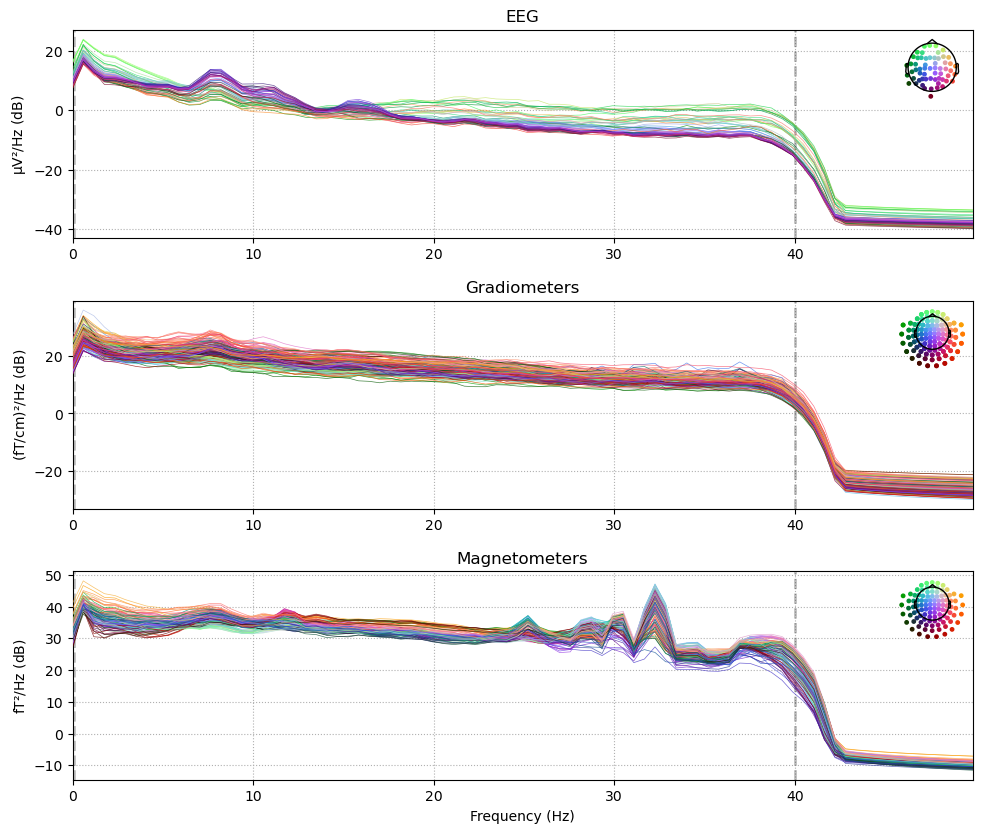

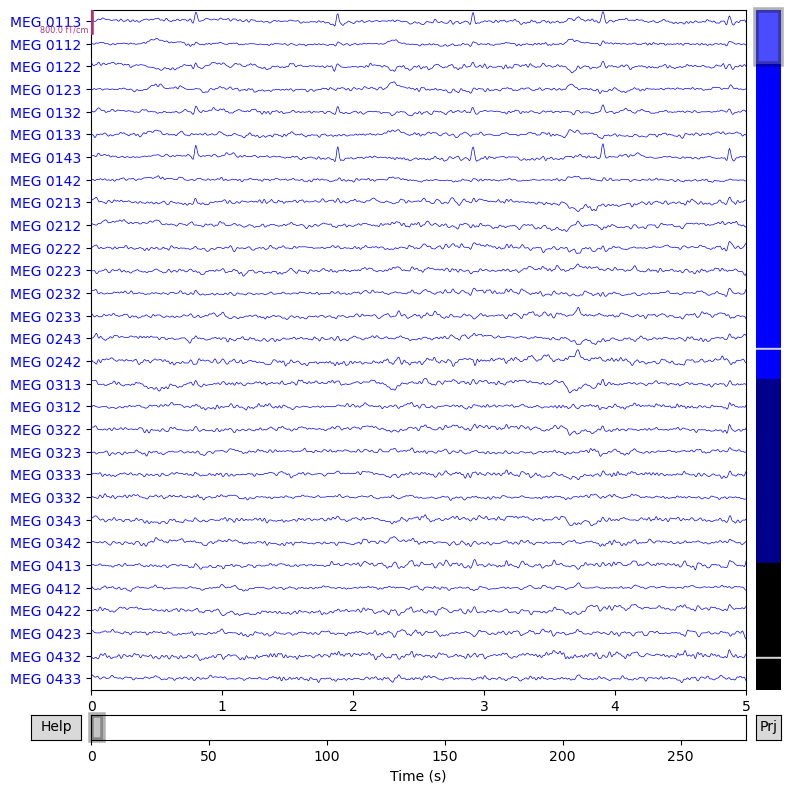

In [8]:
# plot PSD power spectral density
#  In the PSD plot, we’ll only plot frequencies below 50 Hz (since our data are low-pass filtered at 40 Hz)

raw.plot_psd(fmax = 50);# frequency
raw.plot(duration = 5, n_channels = 30);

In [ ]:
# variety of preprocessing approaches and techniques 
# (maxwell filtering, signal-space projection, independent components analysis, filtering, downsampling, etc)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.9s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


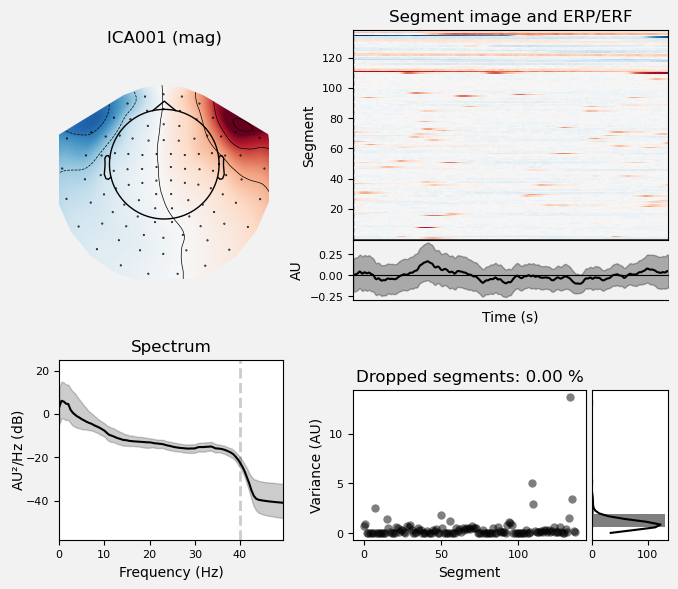

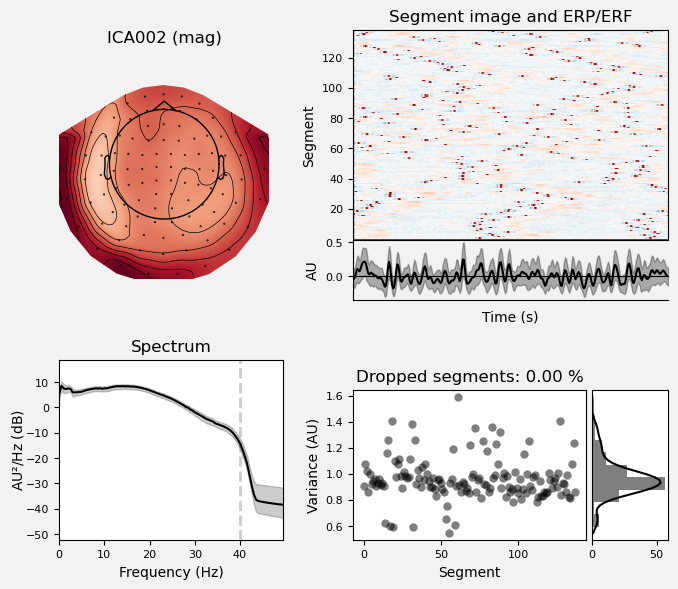

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [9]:
# clearn data with ndependent components analysis (ICA)
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components = 20, random_state = 42, max_iter = 800)
ica.fit(raw)
ica.exclude = [1, 2]
ica.plot_properties(raw, picks = ica.exclude)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


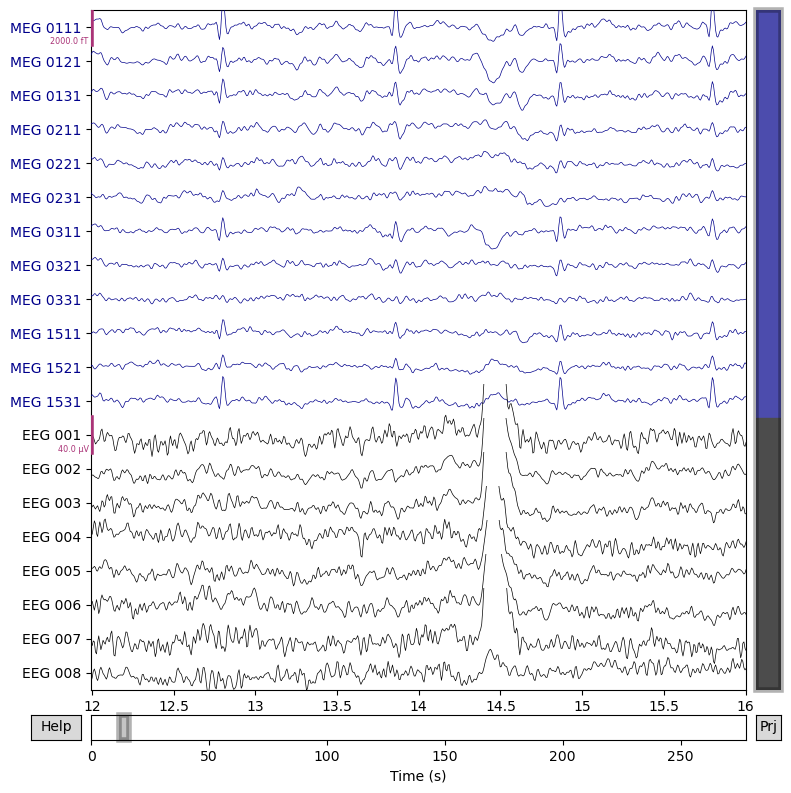

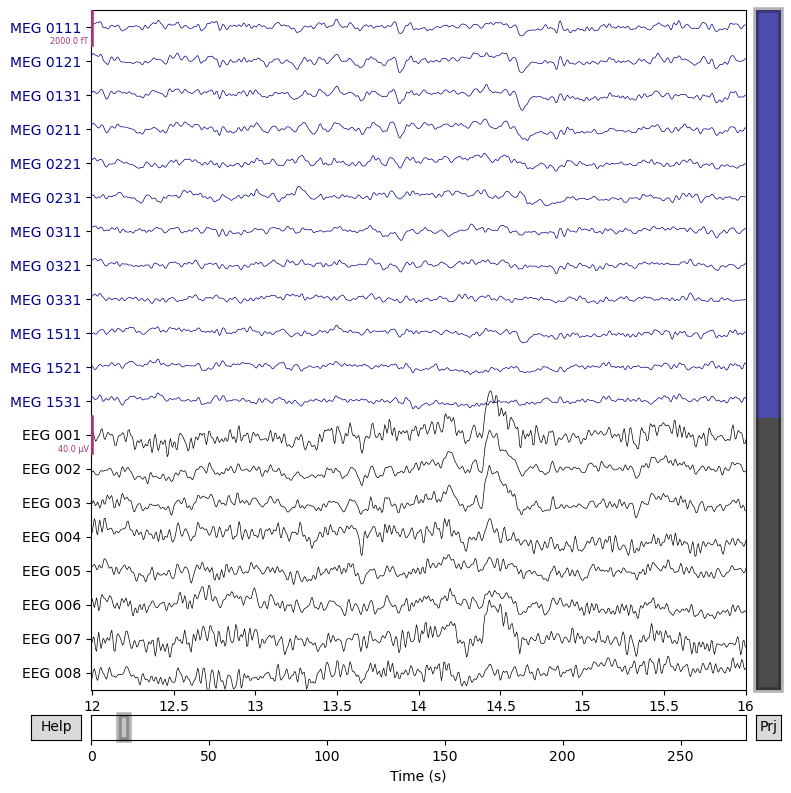

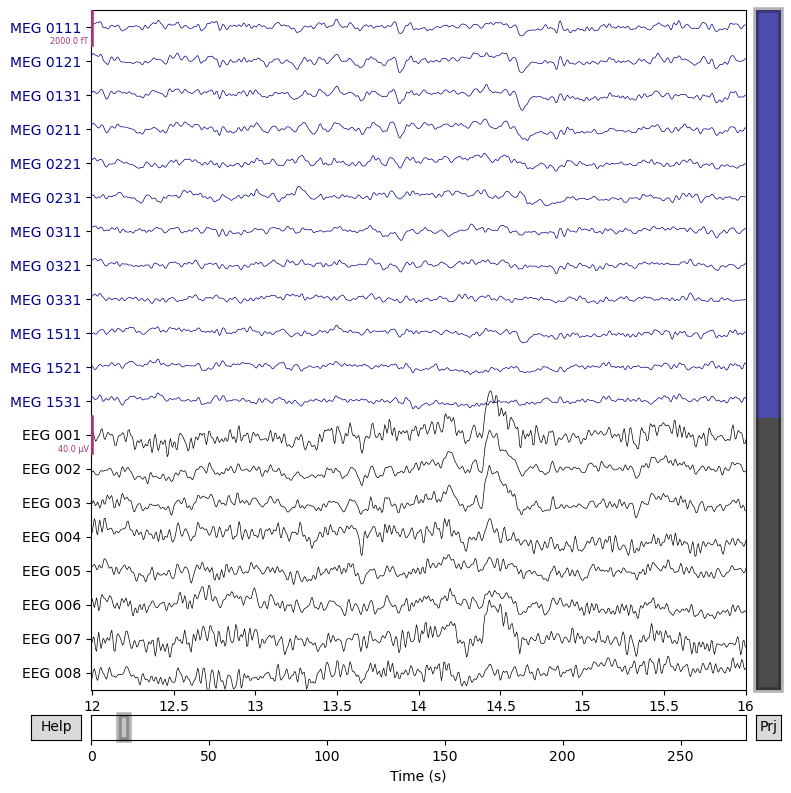

In [10]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]   
orig_raw.plot(order = chan_idxs, start = 12, duration = 4)   # original raw
raw.plot(order = chan_idxs, start = 12, duration = 4)   # # after ica

# we can see the the EEG signalS reduced after ica

# detect events

In [11]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

# array datatype [sample number, middle usually ignored,  integer event ID]


# Event ID
# Condition
# 1
# auditory stimulus (tone) to the left ear
# 2
# auditory stimulus (tone) to the right ear
# 3
# visual stimulus (checkerboard) to the left visual field
# 4
# visual stimulus (checkerboard) to the right visual field
# 5
# smiley face (catch trial)
# 32
# subject button press

319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [12]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

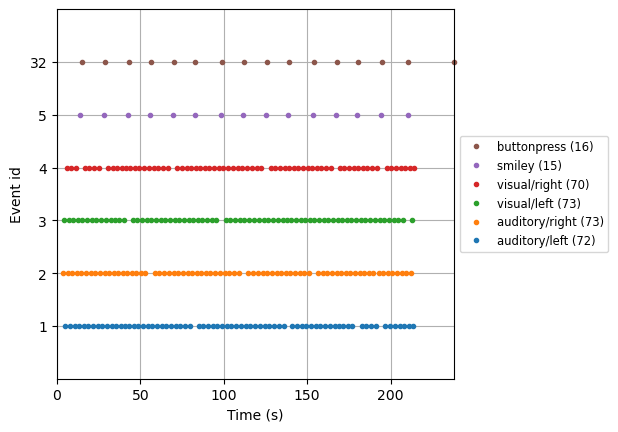

In [13]:
fig = mne.viz.plot_events(events, event_id = event_dict, sfreq = raw.info['sfreq'],
                          first_samp = raw.first_samp)

# epoching data

In [14]:
reject_criteria = dict(mag = 4000e-15,     # 4000 fT
                       grad = 4000e-13,    # 4000 fT/cm
                       eeg = 150e-6,       # 150 µV
                       eog = 250e-6)       # 250 µV

In [15]:
epochs = mne.Epochs(raw, events, event_id = event_dict, tmin = -0.2, tmax = 0.5,
                    reject = reject_criteria, preload = True)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


In [16]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
del raw, epochs  # free up memory

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


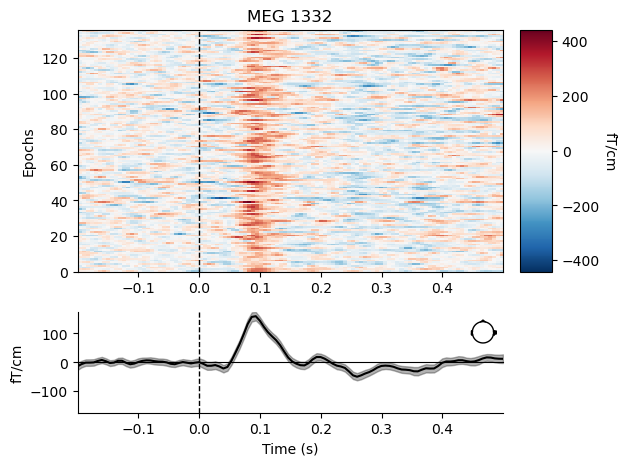

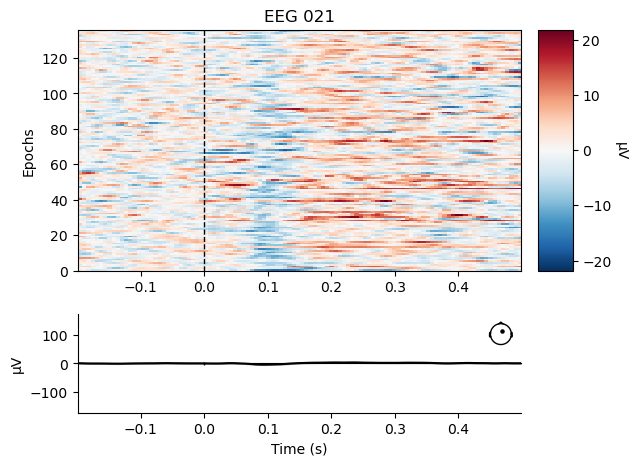

In [17]:
aud_epochs.plot_image(picks=['MEG 1332', 'EEG 021']);

# Time-frequency analysis

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
No baseline correction applied


[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:    5.1s finished


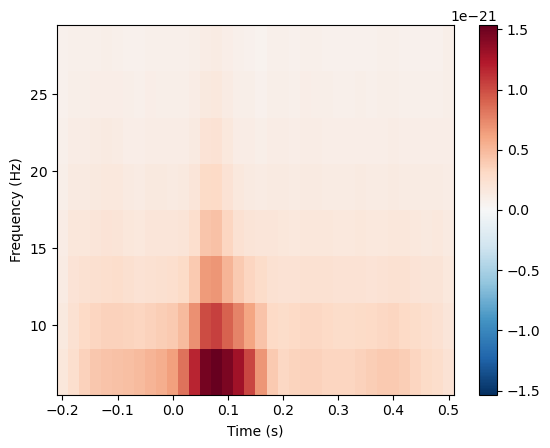

[<Figure size 640x480 with 2 Axes>]

In [18]:
# note: not only time frequency calculation, but also power spectral density, cross-specitral density

frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['MEG 1332'])

# evaluating evoked responses

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


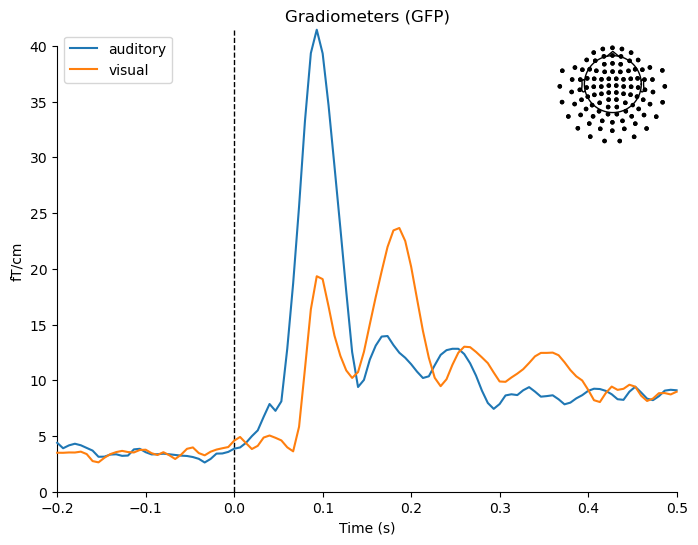

combining channels using "gfp"
combining channels using "gfp"


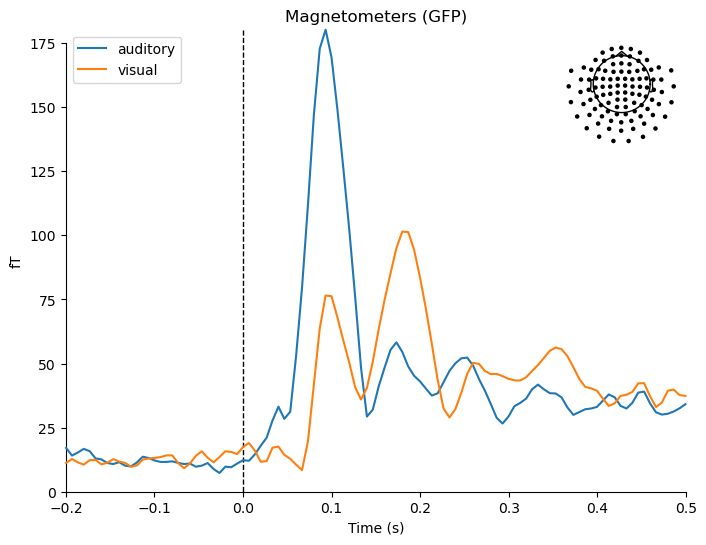

combining channels using "gfp"
combining channels using "gfp"


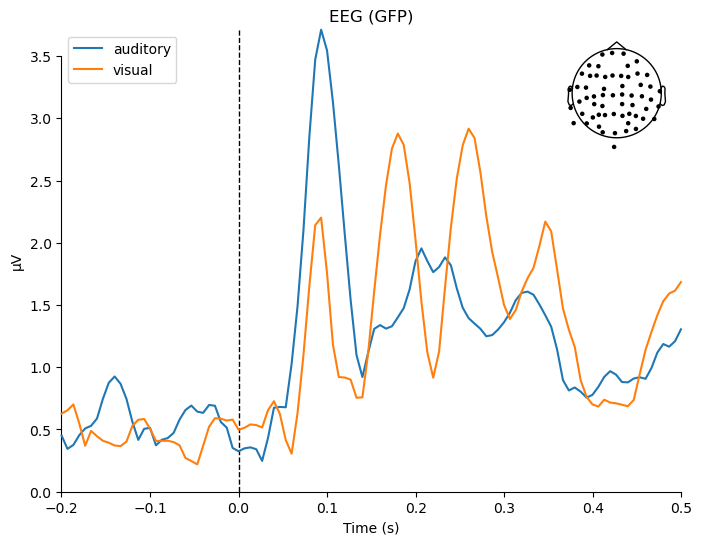

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [19]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


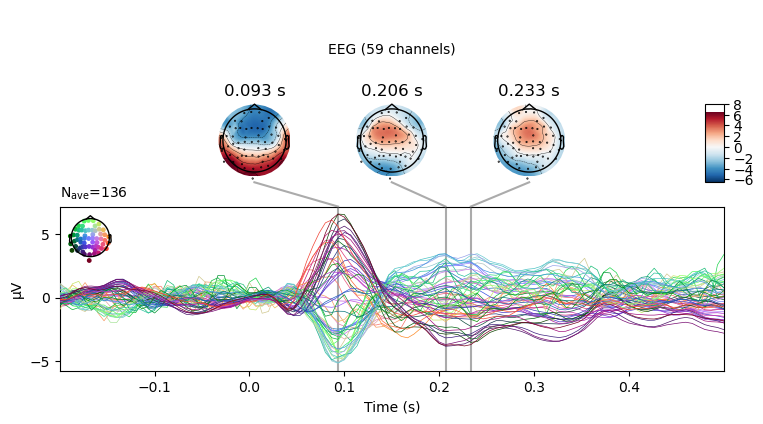

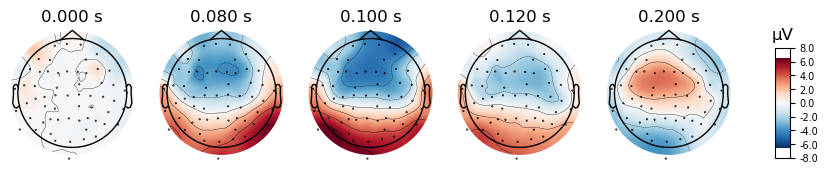

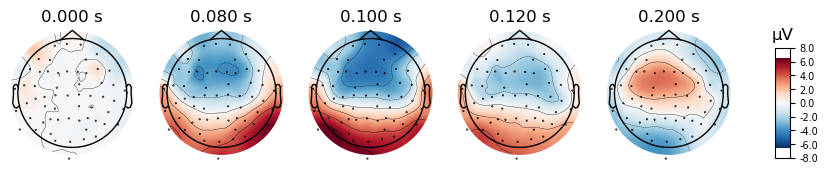

In [20]:
# we just check the EEG channels, and auditory evoked N100 - P200 patern
aud_evoked.plot_joint(picks = 'eeg')
aud_evoked.plot_topomap(times = [0., 0.08, 0.1, 0.12, 0.2], ch_type = 'eeg')

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


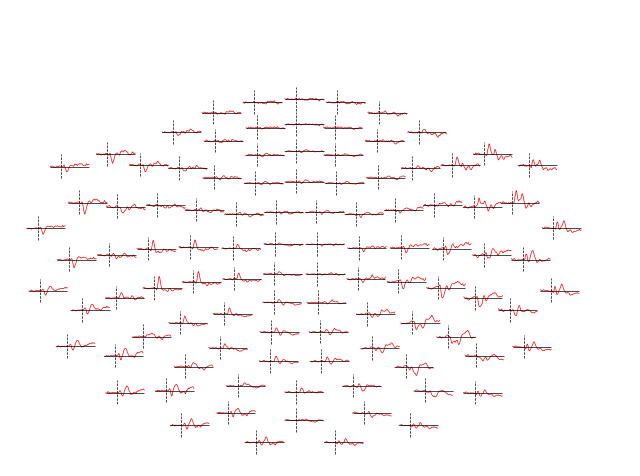

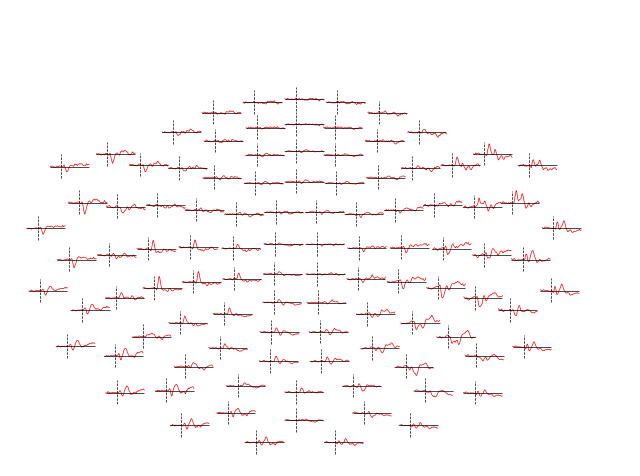

In [21]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick_types(meg='mag').plot_topo(color='r', legend=False)

In [22]:
# load inverse operator
inverse_operator_file = (sample_data_folder / 'MEG' / 'sample' /
                         'sample_audvis-meg-oct-6-meg-inv.fif')
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.
lambda2 = 1. / snr ** 2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(vis_evoked, inv_operator,
                                     lambda2=lambda2,
                                     method='MNE')  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing p

In [27]:
# path to subjects' MRI files
subjects_dir = sample_data_folder / 'subjects'
# plot the STC
stc.plot(initial_time=0.1, hemi='split', views=['lat', 'med'],
         subjects_dir=subjects_dir)

Using control points [8.67481781e-11 1.07519104e-10 4.49141877e-10]


/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


AttributeError: layout